# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this notebook we will find the most similar neighborhoods between Saint Petersburg and Berlin in terms of population density and types of venues, which reside in those neighborhoods

People, choosing to live in a different city may want to live in a neighbourhood somewhat familiar to one they currently live in in terms of venues they have around - someone who enjoys living in a quite place with a park and sport complex nearby might want to live in a neighborhood with a similar vibe, yet in another city or even a country. 

Thus, it will be nice to have a possibility to compare the neighborhoods of two cities - service, providing such functionality, might be included in a bigger mapping/navigation platform or exist independantly. The present notebook is an example of comparison between the neighborhoods of two cities, namely Saint Petersburg and Berlin - both have a status of cultural and educational capitals of their countries and are similar in metropolitan population and average population density (~6 200 000 inh. and ~4 000 inh./km^2 respectively) 

## Data <a name="data"></a>

Data, used for the project, consists of:
<ol>
<li> Borough, name, population and area of each neighborhood for both cities, taken from Wikipedia:

 <ul>
       <li>For Saint Petersburg:<a href="https://ru.wikipedia.org/wiki/%D0%90%D0%B4%D0%BC%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%82%D0%B5%D1%80%D1%80%D0%B8%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0">Wiki page for Saint Petersburg</a>
          <li>For Berlin:<a href="https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin">Wiki page for Berlin</a> 
 </ul>   

<li> OpenStreetMap data on borough and city boundaries
<li> ArcGis coordinates for points in each neighborhood
<li> Foursquare data on venues in each neighborhood, gathered using Foursquare API
</ol>


Start with importing all the libraries we will need

In [2]:
#working with vectors and matricies
import numpy as np
import pandas as pd

#parsing web pages
from bs4 import BeautifulSoup
import urllib

#plotting libraries
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import branca
from branca.colormap import linear
from matplotlib.patches import Ellipse
%matplotlib inline

#regular expressions,time delay and transliteration
import re
import time
from transliterate import translit, get_available_language_codes

#HTML code handling
import requests
from IPython.core.display import display, HTML
from IPython.display import IFrame

#working with geographical data and maps
import json
import geojson
from geojson import Feature, FeatureCollection, dump
from shapely.wkt import loads
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
import geocoder

#clustering model
from sklearn.cluster import KMeans 

Let's find the coordinates of both cities - we will use it to build the maps

In [3]:
#getting the ccordinates of both cities
geolocator = Nominatim(user_agent="SP to BE")
addressSP='Saint Petersburg, Russia'
addressBE='Berlin, Germany'
locationSP=geolocator.geocode(addressSP)
latitudeSP = locationSP.latitude
longitudeSP = locationSP.longitude
locationBE=geolocator.geocode(addressBE)
latitudeBE = locationBE.latitude
longitudeBE = locationBE.longitude
print('The geographical coordinates of Saint Petersburg are {}, {}.'.format(latitudeSP, longitudeSP))
print('The geographical coordinates of Berlin are {}, {}.'.format(latitudeBE, longitudeBE))

The geographical coordinates of Saint Petersburg are 59.9606739, 30.1586551.
The geographical coordinates of Berlin are 52.5170365, 13.3888599.


In [4]:
#defining the function which will create a list from the html string of a table
def tableDataText(table):       
    rows = []
    trs = table.find_all('tr')
    headerow = [td.get_text(strip=True) for td in trs[0].find_all('th')] # header row
    if headerow: # if there is a header row include first
        rows.append(headerow)
        trs = trs[1:]
    for tr in trs: # for every table row
        rows.append([td.get_text(strip=True) for td in tr.find_all('td')]) # data row
    return rows

To get the neighborhood data we parse the table from the Wikipedia page, clean it and convert to a Pandas dataframe - let's start from the Saint Petersburg

In [5]:
#Parsing the Wikipedia page with table of Saint Petersburg neighborhoods
urlSP='https://ru.wikipedia.org/wiki/%D0%90%D0%B4%D0%BC%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%82%D0%B5%D1%80%D1%80%D0%B8%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0'
html_docSP = requests.get(urlSP)
html_docSP='\"\"\"'+html_docSP.text+'\"\"\"'#adding the quotas necessary for BeautifulSoup
soupSP = BeautifulSoup(html_docSP, "html.parser")#creating a BeautifulSoup object with html document in it
tableSP = soupSP.find_all('table')[1]#cutting out the table from the html code of entire page
list_table = tableDataText(tableSP) #getting a table from an html string using the function
dfSP=pd.DataFrame(list_table) #converting a list to a Pandas dataframe

#Prettifying the dataframe

dfSP.columns = dfSP.iloc[0] #replacing the header with a top row and reindexing the dataframe
dfSP = dfSP.reindex(dfSP.index.drop(0)).reset_index(drop=True) 
dfSP.columns.name = None
dfSP=dfSP.iloc[:,[4,9,7,8]] #Cutting out only the colomns we need
dfSP.columns=['Neighborhood','Borough','Area','Population']
#Removing the garbage
dfSP['Area']=dfSP['Area'].str.replace(',','.')
for i in range(0,111):
 dfSP['Population'][i]=re.sub("\[2\]",'',dfSP['Population'][i])
 dfSP['Population'][i]=re.sub('\D','',dfSP['Population'][i])
dfSP = dfSP.astype({'Neighborhood': str, 'Borough': str,'Area':float,'Population':int})
dfSP['Density']=dfSP['Population']/dfSP['Area']
dfSP=dfSP.round({'Density': 1})
dfSP['City']='Saint Petersburg'
dfSP=dfSP.sort_values(by='Density', ascending=False)
print('Shape of the Saint Petersburg dataframe is ',dfSP.shape)
dfSP.head()

Shape of the Saint Petersburg dataframe is  (111, 6)


Neighborhood         Borough  Area  Population  Density  \
38         Металлострой      Колпинский  1.12       30479  27213.4   
75            Оккервиль         Невский  2.49       67659  27172.3   
24             Северный     Калининский  2.15       54106  25165.6   
110  Владимирский округ     Центральный  2.43       58816  24204.1   
44            Юго-Запад  Красносельский  2.84       68503  24120.8   

                 City  
38   Saint Petersburg  
75   Saint Petersburg  
24   Saint Petersburg  
110  Saint Petersburg  
44   Saint Petersburg

Wikipedia page with Berlin neighborhoods has individual tables for each borough, so we parse them all and combine to a dataframe of identical format

In [6]:
#parsing the table with Berlin neighborhoods
urlBE='https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin'
html_docBE = requests.get(urlBE)
html_docBE='\"\"\"'+html_docBE.text+'\"\"\"'
soupBE = BeautifulSoup(html_docBE, "html.parser")
#creating list of Berlin Boroughs
boroughsBE=['Mitte','Friedrichshain-Kreuzberg','Pankow','Charlottenburg-Wilmersdorf','Spandau','Steglitz-Zehlendorf','Tempelhof-Schöneberg','Neukölln','Treptow-Köpenick','Marzahn-Hellersdorf','Lichtenberg','Reinickendorf']
dfBE=pd.DataFrame() #creating a blank Berlin dataframe 
#Going through all the individual borough tables 
for i in range(0,12):
 tableBE = soupBE.find_all('table')[i+2]
 list_table = tableDataText(tableBE) #getting a table from an html string using the function
 df=pd.DataFrame(list_table) #converting a list to a Pandas dataframe
 df.columns = df.iloc[0] #replacing the header with a first row
 df=df.drop(df.index[0])
#prettifying the dataframe
 df['Borough']=boroughsBE[i] 
 df=df.iloc[:,[0,5,1,2]]
 df.columns=['Neighborhood','Borough','Area','Population']
 df = df.astype({'Neighborhood': str, 'Borough': str,'Area':float,'Population':str})
 df['Population']=df['Population'].str.replace(',','').astype(int)
 df['Neighborhood']=df['Neighborhood'].str[6:]
 dfBE=dfBE.append(df).reset_index(drop=True)

dfBE['Density']=dfBE['Population']/dfBE['Area']
dfBE=dfBE.round({'Density': 1})
dfBE['City']='Berlin'
dfBE=dfBE.sort_values(by='Density', ascending=False)
print('Shape of the Berlin dataframe is ',dfBE.shape)
dfBE.head()

Shape of the Berlin dataframe is  (96, 6)


Neighborhood                   Borough   Area  Population  Density  \
45      Friedenau      Tempelhof-Schöneberg   1.65       26736  16203.6   
83      Fennpfuhl               Lichtenberg   2.12       30932  14590.6   
7       Kreuzberg  Friedrichshain-Kreuzberg  10.40      147227  14156.4   
5   Gesundbrunnen                     Mitte   6.13       82729  13495.8   
54   Gropiusstadt                  Neukölln   2.66       35844  13475.2   

      City  
45  Berlin  
83  Berlin  
7   Berlin  
5   Berlin  
54  Berlin

We will need a combined dataframe with neighborhood data for both cities, so we concatinate the two

In [7]:
#Combined dataframe for both cities
dfMerged=pd.concat([dfSP,dfBE]).sort_values(by='Density', ascending=False)

dfMerged.head()

Neighborhood         Borough  Area  Population  Density  \
38         Металлострой      Колпинский  1.12       30479  27213.4   
75            Оккервиль         Невский  2.49       67659  27172.3   
24             Северный     Калининский  2.15       54106  25165.6   
110  Владимирский округ     Центральный  2.43       58816  24204.1   
44            Юго-Запад  Красносельский  2.84       68503  24120.8   

                 City  
38   Saint Petersburg  
75   Saint Petersburg  
24   Saint Petersburg  
110  Saint Petersburg  
44   Saint Petersburg

To compare the density distrubution across the area in both cities, we need some geographical data

We already have the center coordinates for both cities, now let's loop through the neighborhoods dataframe and get the coordinates for points in each of them from ArcGis

In [8]:
#Getting coordinates for all the neighborhoods in Saint Petersburg
for i in range(len(dfSP['Neighborhood'])): #adding the latitude and longitude to a dataframe for each neighborhood
 g=geocoder.arcgis('{} округ,{} район,Санкт Петербург, Россия'.format(dfSP.loc[i,'Neighborhood'],dfSP.loc[i,'Borough']))
 dfSP.loc[i,'Latitude']=g.latlng[0]
 dfSP.loc[i,'Longitude']=g.latlng[1]
 time.sleep(0.1) #time delay to avoid mistakes from arcgis

dfSP.head()

Neighborhood         Borough  Area  Population  Density  \
38         Металлострой      Колпинский  1.12       30479  27213.4   
75            Оккервиль         Невский  2.49       67659  27172.3   
24             Северный     Калининский  2.15       54106  25165.6   
110  Владимирский округ     Центральный  2.43       58816  24204.1   
44            Юго-Запад  Красносельский  2.84       68503  24120.8   

                 City  Latitude  Longitude  
38   Saint Petersburg  59.80784   30.57332  
75   Saint Petersburg  59.91617   30.48941  
24   Saint Petersburg  60.04148   30.39120  
110  Saint Petersburg  59.92620   30.34826  
44   Saint Petersburg  59.85573   30.20475

In [9]:
#Getting coordinates for all the neighborhoods in Berlin
for i in range(len(dfBE['Neighborhood'])): #adding the latitude and longitude to a dataframe for each neighborhood
 if dfBE.loc[i,'Neighborhood']=='Lichterfelde': #geocoding without borough name for this neighborhood returned incorrect results
    g=geocoder.arcgis('{} orsteil,{} bezirk, Berlin, Germany'.format(dfBE.loc[i,'Neighborhood'],dfBE.loc[i,'Borough']))
 else:
    g=geocoder.arcgis('{} orsteil,Berlin, Germany'.format(dfBE.loc[i,'Neighborhood']))
 dfBE.loc[i,'Latitude']=g.latlng[0]
 dfBE.loc[i,'Longitude']=g.latlng[1]
 time.sleep(0.05) #time delay to avoid mistakes from arcgis

dfBE.head()

Neighborhood                   Borough   Area  Population  Density  \
45      Friedenau      Tempelhof-Schöneberg   1.65       26736  16203.6   
83      Fennpfuhl               Lichtenberg   2.12       30932  14590.6   
7       Kreuzberg  Friedrichshain-Kreuzberg  10.40      147227  14156.4   
5   Gesundbrunnen                     Mitte   6.13       82729  13495.8   
54   Gropiusstadt                  Neukölln   2.66       35844  13475.2   

      City  Latitude  Longitude  
45  Berlin  52.47297   13.33269  
83  Berlin  52.52773   13.46654  
7   Berlin  52.49382   13.38358  
5   Berlin  52.55619   13.37710  
54  Berlin  52.42472   13.47370

Okay! Now we have coordinates for each neighborhood in both cities, that will allow us to built the city maps and add a neighborhood markers on top

We will also create a heatmap for each city, so we need the boundaries file for that

 OpenStreetMap has boundaries files of individual boroughs for Saint Petersburg, but not the boundaries of the entire city, so we will combine the borough boundaries into a merged file. To do so, we will add the OpenStreetMap Relation ID of each borough to a borough dataframe

In [10]:
# Creating a list of relation ID's from OpenStreetMap for each Saint Petersburg borough
RelationsSP={'Borough':['Адмиралтейский', 'Василеостровский', 'Выборгский', 'Калининский',
       'Кировский', 'Колпинский', 'Красногвардейский', 'Красносельский',
       'Кронштадтский', 'Курортный', 'Московский', 'Невский',
       'Петроградский', 'Петродворцовый', 'Приморский', 'Пушкинский',
       'Фрунзенский', 'Центральный'],'RelationID':[1114193,1114252,1114354,1114806,1114809,337424,1114895,363103,1115082,1115366,338636,368287,1114905,367375,1115367,338635,369514,1114902]}

# Preparing a Borough Density dataframe for Saint Peterburg map
df_RelationsSP=pd.DataFrame(data=RelationsSP)
df_RelationsSP.set_index('Borough',inplace=True)
BoroughDensity=pd.DataFrame(data=dfSP.groupby('Borough')['Population'].sum()/dfSP.groupby('Borough')['Area'].sum())
BoroughDensity.columns=['Density']
df_BoroughsSP=pd.DataFrame()
df_BoroughsSP=pd.merge(df_RelationsSP,BoroughDensity,on='Borough')
df_BoroughsSP.reset_index(inplace=True)
df_BoroughsSP=df_BoroughsSP.round({'Density': 1})

# Preparing a Geojson file from Saint Petersburg from files of individual boroughs
features = []

for index in range(len(df_BoroughsSP.index)):
 jsonurl='http://polygons.openstreetmap.fr/get_geojson.py?id='+str(df_BoroughsSP.RelationID[index])+'&params=0'
 with urllib.request.urlopen(jsonurl) as url:
    Geometry=json.loads(url.read().decode())
    features.append(Feature(geometry=Geometry, properties={"name": df_BoroughsSP.Borough[index],"density":df_BoroughsSP.Density[index]}))
    
feature_collection = FeatureCollection(features)
with open('myfile.geojson', 'w') as f:
   dump(feature_collection, f)
with open('myfile.geojson', 'r') as f:    
   GeodataSP=json.load(f) #Geojson file with boundaries of the Saint Petersburg, broken down to individual boroughs

df_BoroughsSP.head()

Borough  RelationID  Density
0    Адмиралтейский     1114193  12301.4
1  Василеостровский     1114252  11514.0
2        Выборгский     1114354   4127.2
3       Калининский     1114806  13170.4
4         Кировский     1114809   9314.4

Now we have all the data to make a heatmap of Saint Petersburg borough densities, so let's prepare the data for Berlin

Luckily, whole city boundary for Berlin is available, so we'll just upload the boundary file add prepare a borough dataframe

In [11]:
# Preparing a Borough Density dataframe for Berlin map
df_BoroughsBE=pd.DataFrame(data=dfBE.groupby('Borough')['Population'].sum()/dfBE.groupby('Borough')['Area'].sum())
df_BoroughsBE.columns=['Density']
df_BoroughsBE=df_BoroughsBE.reset_index()
df_BoroughsBE=df_BoroughsBE.round({'Density': 1})

#Loading the Geojson file for Berlin
jsonurl='https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson'
with urllib.request.urlopen(jsonurl) as url:
 GeodataBE=json.loads(url.read().decode()) #Geojson file with boundaries of Berlin

#Setting the names in boroughs dataframe same as names in JSON file
JsonBorougsBE = []
for index in range(len(GeodataBE['features'])):
    JsonBorougsBE.append(GeodataBE['features'][index]['properties']['name'])
    
df_BoroughsBE=df_BoroughsBE.sort_values('Borough')
df_BoroughsBE['Borough']=sorted(JsonBorougsBE)

df_BoroughsBE.head()

Borough  Density
0  Charlottenburg-Wilmersdorf   4804.4
1    Friedrichshain-Kreuzberg  12947.3
2                 Lichtenberg   4837.7
3         Marzahn-Hellersdorf   3972.2
4                       Mitte   8269.4

We will also add an interactive layer to the maps, so that the borough name and density will be visible with navifating on it. This layer will requare a separate dataframe, contaning both density and geometry data and we will prepare those for both cities out of what we already have

In [12]:
#Creating a file for interactive chloropleth layer 
geoSP=gpd.read_file(str(feature_collection))
    
Geometry=[] #initializing a vector with geometry data
#looping through the rows of dataframe, obtaining the geodata and convirting it to suitable format
for i in range(len(geoSP.name)):
    geometry=str(geoSP.loc[i,'geometry'])
    start=geometry.find('MULTIPOLYGON')
    end=geometry.find('))))')
    string=geometry[start:end]+')))'
    geometry = loads(string)
    Geometry.append(geometry)
geoSP['geometry']=Geometry
geoSP.head()  

density              name  \
0  12301.4    Адмиралтейский   
1  11514.0  Василеостровский   
2   4127.2        Выборгский   
3  13170.4       Калининский   
4   9314.4         Кировский   

                                            geometry  
0  MULTIPOLYGON (((30.25023 59.90129, 30.25112 59...  
1  MULTIPOLYGON (((30.18468 59.95472, 30.18449 59...  
2  MULTIPOLYGON (((30.07276 60.09727, 30.07078 60...  
3  MULTIPOLYGON (((30.34405 59.97749, 30.34419 59...  
4  MULTIPOLYGON (((30.16799 59.88702, 30.16781 59...

Dataframe for interactive layer of Saint Petersburg is ready, now let's make the same for Berlin:

In [13]:
#Creating a file for interactive chloropleth layer 
feature_collection = FeatureCollection(GeodataBE['features'])
geoBE=gpd.read_file(str(feature_collection))
geoBE=geoBE[['name','geometry']]

Geometry=[] #initializing a vector with geometry data
#looping through the rows of dataframe, obtaining the geodata and convirting it to suitable format
for i in range(len(geoBE.name)):
    geometry=str(geoBE.loc[i,'geometry'])
    start=geometry.find('MULTIPOLYGON')
    end=geometry.find('))))')
    string=geometry[start:end]+')))'
    geometry = loads(string)
    Geometry.append(geometry)
geoBE['geometry']=Geometry
geoBE=geoBE.sort_values('name')
geoBE=geoBE.reset_index(drop=True)
geoBE['density']=df_BoroughsBE['Density']
geoBE.head()

name  \
0  Charlottenburg-Wilmersdorf   
1    Friedrichshain-Kreuzberg   
2                 Lichtenberg   
3         Marzahn-Hellersdorf   
4                       Mitte   

                                            geometry  density  
0  MULTIPOLYGON (((13.31279 52.53231, 13.31292 52...   4804.4  
1  MULTIPOLYGON (((13.42940 52.50857, 13.42924 52...  12947.3  
2  MULTIPOLYGON (((13.50189 52.48258, 13.50162 52...   4837.7  
3  MULTIPOLYGON (((13.51860 52.51454, 13.51874 52...   3972.2  
4  MULTIPOLYGON (((13.40353 52.54021, 13.40419 52...   8269.4

We gained the data to compare the neighborhoods by density now, but how do they compare in terms of venues they have? To find that out, we will first get the venue information in each neighborhood using Foursquare API.

In [14]:
#Defining the keys for Foursquare API
CLIENT_ID = 'JMZZWZQPHQD3T0LH5TSVNIUGPRCTOZCDPUCJMK5YGALS2MXZ' #Foursquare ID
CLIENT_SECRET = 'WR0KHTDPTLZIJOSHZVP5TFAMVEVJVD2LCLZFU0FTRQHRHS4P' #Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [15]:
#defining the function which will return the nearby venues for neighbourhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    LIMIT=50
    for name, lat, lng in zip(names, latitudes, longitudes):           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)   
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
#passing the Saint Petersburg neighborhoods data to a function and assigning the resultant venue list to a dataframe
df_venues_SP = getNearbyVenues(names=dfSP['Neighborhood'],
                                   latitudes=dfSP['Latitude'],
                                   longitudes=dfSP['Longitude']
                                  )



In [19]:
#Same for Berlin
df_venues_BE = getNearbyVenues(names=dfBE['Neighborhood'],
                                   latitudes=dfBE['Latitude'],
                                   longitudes=dfBE['Longitude']
                                  )

#Combined dataframe with Saint-Petersburg and Berlin venues
df_venues=pd.concat([df_venues_SP,df_venues_BE])
df_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Металлострой               59.80784                30.57332   
1  Металлострой               59.80784                30.57332   
2  Металлострой               59.80784                30.57332   
3  Металлострой               59.80784                30.57332   
4  Металлострой               59.80784                30.57332   

                                 Venue  Venue Latitude  Venue Longitude  \
0                              Код-Бар       59.808585        30.577101   
1           Площадь при ДК Маяковского       59.809080        30.575463   
2                                Лилия       59.809894        30.569623   
3                    Гостиница «Ижора»       59.807543        30.569741   
4  Добрый ФЕРМЕР (Продуктовый магазин)       59.809704        30.572977   

      Venue Category  
0               Café  
1              Plaza  
2         Restaurant  
3              Hotel  
4  Convenience Store

So we got a list of venues for each neighborhood - let's see how popular are each of those. To do so, we will create a coloumn for every type of venue and count a number of venues of such type for every given neighborhood 

In [20]:
#preparing the dataframe with types of venues in each neighborhood
onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="") #creating a dataframe with coloumn for each type of venue
onehot['Neighborhood'] = df_venues['Neighborhood'] # add neighborhood column to dataframe
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1]) # move neighborhood column to the first column
onehot = onehot[fixed_columns]
grouped = onehot.groupby('Neighborhood').mean().reset_index() #grouping the rows by neighborhood to get the mean number of each type of venue in each neighborhood
grouped.head()

Neighborhood  Zoo Exhibit  ATM  Accessories Store  Adult Boutique  \
0             Adlershof          0.0  0.0                0.0             0.0   
1  Alt-Hohenschönhausen          0.0  0.0                0.0             0.0   
2           Alt-Treptow          0.0  0.0                0.0             0.0   
3          Altglienicke          0.0  0.0                0.0             0.0   
4        Baumschulenweg          0.0  0.0                0.0             0.0   

   Advertising Agency  African Restaurant  Airport Terminal  \
0                 0.0                 0.0               0.0   
1                 0.0                 0.0               0.0   
2                 0.0                 0.0               0.0   
3                 0.0                 0.0               0.0   
4                 0.0                 0.0               0.0   

   American Restaurant  Antique Shop  ...  Vietnamese Restaurant  \
0                  0.0           0.0  ...               0.000000   
1                  0.0           0.0  ...               0.000000   
2                  0.0           0.0  ...               0.000000   
3                  0.0           0.0  ...               0.000000   
4                  0.0           0.0  ...               0.045455   

   Volleyball Court  Warehouse Store  Waterfront  Whisky Bar  Wine Bar  \
0               0.0              0.0         0.0         0.0       0.0   
1               0.0              0.0         0.0         0.0       0.0   
2               0.0              0.0         0.0         0.0       0.0   
3               0.0              0.0         0.0         0.0       0.0   
4               0.0              0.0         0.0         0.0       0.0   

   Wine Shop  Women's Store  Yemeni Restaurant  Yoga Studio  
0        0.0            0.0                0.0          0.0  
1        0.0            0.0                0.0          0.0  
2        0.0            0.0                0.0          0.0  
3        0.0            0.0                0.0          0.0  
4        0.0            0.0                0.0          0.0  

[5 rows x 353 columns]

Great! Now we know the weight of each venue type in each neighborhood and this data is perfect for clusterization model, but it's also too big and not very convinient to percieve the differencies by eye,so let's transform it to a simpler form

For each neighborhood we will only leave the most popular venue types, adding a coloumn for each priority level - that will make it easier to see, what's popular in each neighborhood

In [21]:
#defining the function which will sort the venues based on their popularity
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
#Creating a dataframe with top venues in each neighborhood
num_top_venues = 10 #number of top venues we look at for each neighborhood

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']
z=neighborhoods_venues_sorted.copy()

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

    
neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0             Adlershof               Cluster           Supermarket   
1  Alt-Hohenschönhausen               Cluster             Drugstore   
2           Alt-Treptow               Cluster           Boat Rental   
3          Altglienicke               Cluster           Supermarket   
4        Baumschulenweg               Cluster              Bus Stop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0     Trattoria/Osteria           Pizza Place             Drugstore   
1                 Hotel           Supermarket          Liquor Store   
2         Boat or Ferry                  Lake            Restaurant   
3         Bowling Alley        Discount Store      Indoor Play Area   
4             Drugstore                  Café           Supermarket   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         Shopping Mall         Movie Theater         Tanning Salon   
1        Discount Store          Tram Station      Asian Restaurant   
2                  Park        Scenic Lookout    Seafood Restaurant   
3    Falafel Restaurant     Electronics Store        Emergency Room   
4                Bakery      Asian Restaurant    Italian Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0                  Bank       Greek Restaurant  
1           Coffee Shop       Doner Restaurant  
2           Beer Garden             Playground  
3         Event Service            Event Space  
4    Light Rail Station            Flower Shop

Finaly we have all the data we need, so let's start analysing it

## Methodology <a name="methodology"></a>

Having a geographical, population and venue data, we want to give an advice to a person, willing to move to a similar neighborhood of one city to another. To do that, we will compare the neighborhoods and get a list of most suitable neighborhoods at the end. The entire analysis will be done in several steps:

* <b>Collecting the data</b> - we already got the list of the neighborhoods in each city with borough names, areas, total population, density and coordinates of each neighborhood. We also colected the geographical boundaries for each borough and got the venue data for each neighborhood using Foursquare API
* <b>Comparing the neighborhood population density in two cities</b> - we will draw a boxplot and see how the density distributes across the boroughs in each city
* <b>Comparing the density distribution across the city's area</b> - we will make a map to see where the most populated boroughs reside in each city
* <b>Clusterisation of neighborhoods</b> - we will apply the Kmeans algorythm to cluster the neighborhoods of both cities into clusters and then show it on a map
* <b>Combining the density comparison with clusterization results</b> - we will see, how many neighborhoods of each city fall into one cluster with neighborhoods of another city, estimate the number of inhabitants,who live in those neighborhoods and built a final plot, which show appropriate neighborhoods

## Analysis <a name="analysis"></a>

We have all the data we need for our neighborhoods, let's see some basic statistics on it

In [23]:
#basic descriptive statistics for the neighborhoods
dfMerged.describe()

Area     Population       Density
count  207.000000     207.000000    207.000000
mean    11.259324   42325.096618   6945.357971
std     13.868256   34864.552941   6469.056396
min      0.530000     281.000000     28.100000
25%      4.220000   14418.500000   1735.500000
50%      7.110000   35088.000000   4478.000000
75%     12.000000   65024.000000  11147.400000
max    106.630000  154127.000000  27213.400000

There is a huge difference in size and density between the neighborhoods, now let's visualize the data to see which city's neighborhoods are more densely populated
As we have a lot of neighborhoods to plot, the barplot of the entire dataframe would very big, so let's draw a boxplot for each borough to see the distribution of neighborhood density in each

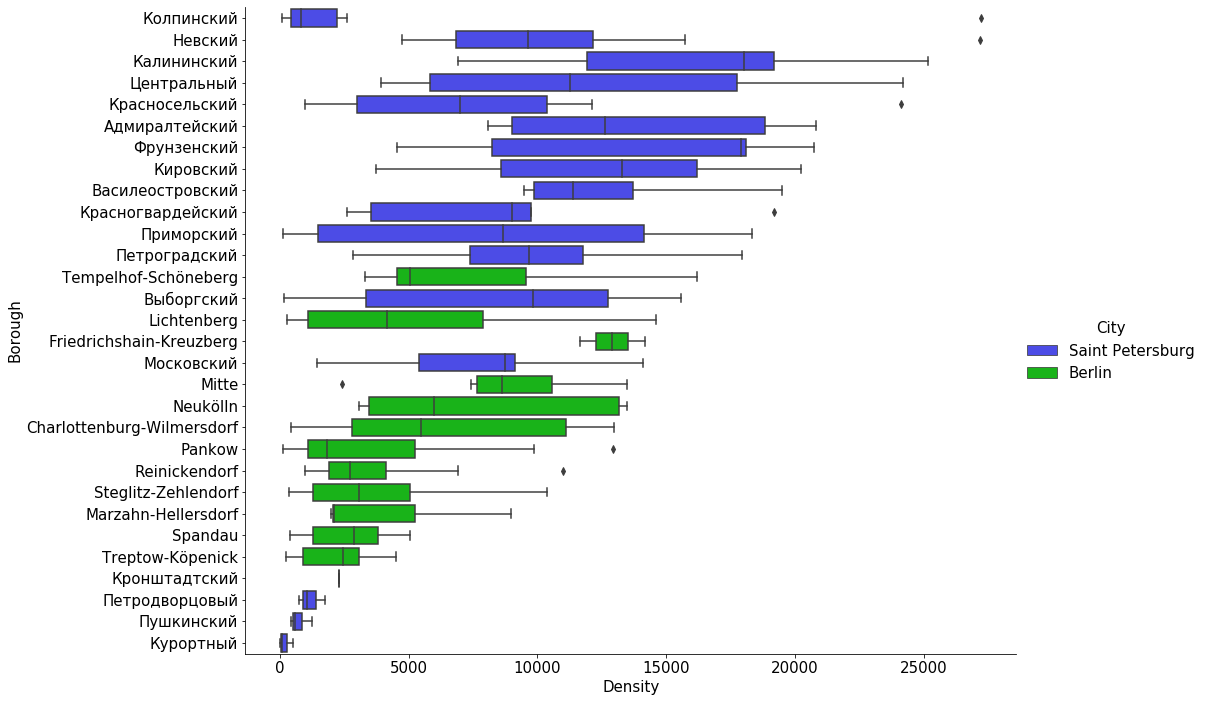

In [24]:
#defining the colours for each city
colordict={'Berlin':'#00CC00','Saint Petersburg':'#3333FF'}

#Box plot for city boroughs
plt.rcParams.update({'font.size': 15})
sns.catplot(x='Density', y='Borough', hue='City',
            kind="box", dodge=False, data=dfMerged,height=10, aspect=1.5,palette=colordict)

Clearly, Saint Peterburg boroughs are mostly more dense than Berlins, yet Saint Peterburg also has four of the least dense boroughs.

So far so good, but it will be even more convinient to show this data on the actual map - the heatmap will be a good representation for density, so let's colour the map according to the population density in each area. As we only have geometry for boroughs, we will use borough densities for coloring the map and add neighborhood densities to the marker labels.

In [25]:
#Creating a map objects for both cities
map_BE = folium.Map(location=[latitudeBE, longitudeBE], zoom_start=10)
map_SP = folium.Map(location=[latitudeSP, longitudeSP], zoom_start=10)

#Making a combined colorscale for Chloropleth layer
minDensity=min(min(df_BoroughsSP.Density),min(df_BoroughsBE.Density))
maxDensity=max(max(df_BoroughsSP.Density),max(df_BoroughsBE.Density))
myscale = np.array([minDensity,maxDensity])
myscale=np.quantile(myscale,[0, 0.25, 0.5, 0.75, 1]).tolist()

#Adding a Chloropleth density layer for Saint Petersburg
chloSP=folium.Choropleth(
    geo_data=GeodataSP,
    name='choropleth',
    data=df_BoroughsSP,
    columns=['Borough', 'Density'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    threshold_scale=myscale,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Density (inh/km^2)',
    highlight=True
)

map_SP.add_child(chloSP)

#Adding a Chloropleth density layer for Berlin
chloBE=folium.Choropleth(
    geo_data=GeodataBE,
    name='choropleth',
    data=df_BoroughsBE,
    columns=['Borough', 'Density'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    threshold_scale=myscale,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Density (inh/km^2)',
    highlight=True
)

map_BE.add_child(chloBE)

#Styling for interactive layer
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}


#Adding a Chloropleth interactive layer for Saint Petersburg
intSP = folium.features.GeoJson(
    geoSP,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name','density'],
        aliases=['Borough name: ','Average density, inh per km^2: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
map_SP.add_child(intSP)

#Adding a Chloropleth interactive layer for Berlin
intBE = folium.features.GeoJson(
    geoBE,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name','density'],
        aliases=['Borough name: ','Average density, inh per km^2: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
map_BE.add_child(intBE)


# Adding markers to Saint Petersburg map
for lat, lng, district, neighborhood, density in zip(dfSP['Latitude'], dfSP['Longitude'], dfSP['Borough'], dfSP['Neighborhood'],dfSP['Density']):
    label = '{}, {} inh/km^2'.format(translit(neighborhood,'ru', reversed=True),density)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SP)
    #map_SP.keep_in_front(intSP,folium.CircleMarker) #Keeping the interactive layer in front

# Adding markers to Berlin map
for lat, lng, district, neighborhood,density in zip(dfBE['Latitude'], dfBE['Longitude'], dfBE['Borough'], dfBE['Neighborhood'],dfBE['Density']):
    label = '{}, {} inh/km^2'.format(neighborhood,density)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False,
        z_index_offset=0).add_to(map_BE)



#Adding the layer control
folium.LayerControl().add_to(map_SP)
folium.LayerControl().add_to(map_BE)

In [26]:
#Displaying the maps together
htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(map_SP.get_root().render().replace('"', '&quot;'),500,500,
                   map_BE.get_root().render().replace('"', '&quot;'),500,500))
htmlmap

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Not surprisingly, the closer to the city center, the more densely populated the boroughs are, with same logic generally applied to neighborhoods.

We can also see that for the most part, the entire city of Berlin is closer to the Saint Petersburg suburbs in terms of population, with only the Friedrichshain-Kreuzberg being an exception

Let's move forward and cluster the neighborhoods by their venues:

In [45]:
# Clustering the neighborhoods based on the venue data
kclusters = 7 # set number of clusters

grouped_clustering = grouped.drop('Neighborhood', 1) #matrix of venue popularity for each neighborhood

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering) # creating a k-means cluster object and fitting it with venue data
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) # adding the cluster number to the venue dataframe 

#creating a dataframe, combining all the data we have for each neighborhood
df_final = pd.concat([dfBE,dfSP]).sort_values(by=['Neighborhood']).reset_index(drop=True)

#adding the venue data and cluster numbers to the final dataframe
df_final = df_final.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_final = df_final.fillna(0)
df_final['Cluster Labels'] = df_final['Cluster Labels'].astype('int32') #casting the cluster labels as integers
df_final.head()

Neighborhood           Borough  Area  Population  Density    City  \
0             Adlershof  Treptow-Köpenick  6.11       15112   2473.3  Berlin   
1  Alt-Hohenschönhausen       Lichtenberg  9.33       41780   4478.0  Berlin   
2           Alt-Treptow  Treptow-Köpenick  2.31       10426   4513.4  Berlin   
3          Altglienicke  Treptow-Köpenick  7.89       26101   3308.1  Berlin   
4        Baumschulenweg  Treptow-Köpenick  4.82       16780   3481.3  Berlin   

    Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  52.437790  13.547780               3               Cluster   
1  52.547060  13.500550               3               Cluster   
2  52.486097  13.478015               0               Cluster   
3  52.420060  13.539690               5               Cluster   
4  52.466690  13.488400               1               Cluster   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Supermarket     Trattoria/Osteria           Pizza Place   
1             Drugstore                 Hotel           Supermarket   
2           Boat Rental         Boat or Ferry                  Lake   
3           Supermarket         Bowling Alley        Discount Store   
4              Bus Stop             Drugstore                  Café   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0             Drugstore         Shopping Mall         Movie Theater   
1          Liquor Store        Discount Store          Tram Station   
2            Restaurant                  Park        Scenic Lookout   
3      Indoor Play Area    Falafel Restaurant     Electronics Store   
4           Supermarket                Bakery      Asian Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0         Tanning Salon                  Bank       Greek Restaurant  
1      Asian Restaurant           Coffee Shop       Doner Restaurant  
2    Seafood Restaurant           Beer Garden             Playground  
3        Emergency Room         Event Service            Event Space  
4    Italian Restaurant    Light Rail Station            Flower Shop

We succesfully diveded the neighborhoods into clusters, based on the venues they have, let's see what the average neighborhood of each cluster looks like

In [46]:
m=grouped
m['Cluster']=df_final['Cluster Labels']
cols = m.columns.tolist()
cols = cols[-1:] + cols[:-1]
m = m[cols].drop(['Neighborhood'],axis=1)
clusterdata=m.groupby('Cluster').sum()
clusterdata=clusterdata.reset_index()

columns = ['Cluster']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

clusterdata_sorted = pd.DataFrame(columns=columns)
clusterdata_sorted['Cluster']=clusterdata['Cluster']

for ind in np.arange(clusterdata.shape[0]):
    clusterdata_sorted.iloc[ind, 1:] = return_most_common_venues(clusterdata.iloc[ind, :], num_top_venues)
    
clusterdata_sorted=clusterdata_sorted.set_index('Cluster',drop=True) 
clusterdata_sorted

1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
Cluster                                                                     
0                  Restaurant                  Park              Bus Stop   
1                        Café                Bakery              Bus Stop   
2               Auto Workshop    Athletics & Sports            Restaurant   
3                 Supermarket          Tram Station                Bakery   
4                  Playground             BBQ Joint            Art Museum   
5                 Supermarket             Drugstore    Chinese Restaurant   
6                    Bus Stop           Supermarket            Restaurant   

        4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
Cluster                                                                     
0           German Restaurant         Auto Workshop              Pharmacy   
1                       Hotel           Coffee Shop    Italian Restaurant   
2                      Bakery                  Park              Boutique   
3                   Drugstore                  Café     German Restaurant   
4                  Restaurant                   Spa              Bus Stop   
5              Discount Store         Bowling Alley           Flower Shop   
6                 Gas Station         Auto Workshop         Train Station   

        7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
Cluster                                                                     
0           Recreation Center                Buffet            Playground   
1            Doner Restaurant                  Park           Supermarket   
2                 Flower Shop             Gastropub        Clothing Store   
3                Soccer Field                  Park         Auto Workshop   
4          Light Rail Station                  Park                Palace   
5                 Snack Place      Doner Restaurant           Beer Garden   
6              Farmers Market     German Restaurant                  Tree   

        10th Most Common Venue  
Cluster                         
0                  Boat Rental  
1                   Restaurant  
2            Food & Drink Shop  
3                        Hotel  
4                        Hotel  
5                    Cable Car  
6           Italian Restaurant

It's fair to say that clusters 0 and 5 are more of a suburban type, while clusters 1 and 6 have more of arecreational venues

Now let's see how clusters distribute geographicaly - to do that, we will recreate the maps, but this time we will paint the neighborhood markers according to the cluster number

In [47]:
#Creating a map objects for both cities
map_SP = folium.Map(location=[latitudeSP, longitudeSP], zoom_start=10)
map_BE = folium.Map(location=[latitudeBE, longitudeBE], zoom_start=10)

#Adding a previously created Chloropleth densitys layer to both maps
map_SP.add_child(chloSP)
map_BE.add_child(chloBE)

#Adding a previously created Chloropleth interactive layers to both maps
map_SP.add_child(intSP)
map_BE.add_child(intBE)

#Setting the color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


#Adding cluster markers to the map
for city,lat, lon, poi, cluster,density in zip(df_final['City'],df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood'], df_final['Cluster Labels'],df_final['Density']):
    if city=='Saint Petersburg':  
      label = folium.Popup(str(translit(poi,'ru', reversed=True)) + ', Cluster ' + str(cluster)+', '+str(density)+' inh/km^2', parse_html=True)
      folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_SP)
    else:
      label = folium.Popup(poi + ', Cluster ' + str(cluster)+', '+str(density)+' inh/km^2', parse_html=True)
      folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_BE)

    
#Adding the layer control
folium.LayerControl().add_to(map_SP)
folium.LayerControl().add_to(map_BE)

In [48]:
#Displaying the maps together
htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(map_SP.get_root().render().replace('"', '&quot;'),500,500,
                   map_BE.get_root().render().replace('"', '&quot;'),500,500))
htmlmap

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


There is clearly a big difference in cluster distribution among the cities - some of the clusters are prevalent in Saint Petersburg, but almost absent in Berlin and vise-versa. Let's take a look on a distribution of clusters among the cities to understand it better

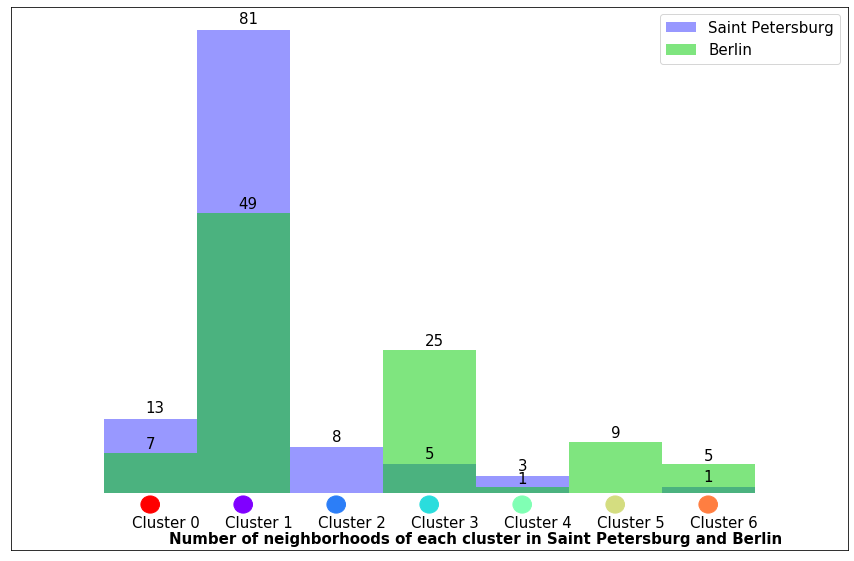

In [51]:
df_ff=df_final[['Cluster Labels','City']]

clusters=np.sort(df_ff['Cluster Labels'].unique())
clustersSP=df_ff[df_ff['City']=='Saint Petersburg'].groupby('Cluster Labels').count()
clustersSP=clustersSP.rename(columns={'City': 'Count'})

clustersBE=df_ff[df_ff['City']=='Berlin'].groupby('Cluster Labels').count()
clustersBE=clustersBE.rename(columns={'City': 'Count'})

x = df_ff[df_ff['City']=='Saint Petersburg']['Cluster Labels']
y = df_ff[df_ff['City']=='Berlin']['Cluster Labels']

bins=np.linspace(0,kclusters,num=kclusters+1)

f, ax = plt.subplots(figsize=(15,10))
ax.set(xlim=[-1,kclusters+1], ylim=[-10, 85]) #Setting the limits for plot display

plt.hist(x, bins, alpha=0.5, label='Saint Petersburg',color=colordict['Saint Petersburg'])
plt.hist(y, bins, alpha=0.5, label='Berlin',color=colordict['Berlin'])
plt.legend(loc='upper right')

#Adding number of clusters for each city
for cluster, count in zip(clustersSP.index,clustersSP['Count']):
 vertical=count+0.5
 horizontal=cluster+0.45
 #horizontal=((kclusters+1)/kclusters)*cluster+0.15
 text=count
 plt.annotate(text, # text to display
             xy=(horizontal, vertical),                    # start the text at at point (year 2008 , pop 30)
             va='bottom',                    # want the text to be vertically 'bottom' aligned
             ha='left',                      # want the text to be horizontally 'left' algned.
            )
for cluster, count in zip(clustersBE.index,clustersBE['Count']):
 vertical=count+0.2
 horizontal=cluster+0.45
 text=count
 plt.annotate(text, # text to display
             xy=(horizontal, vertical),                    # start the text at at point (year 2008 , pop 30)
             va='bottom',                    # want the text to be vertically 'bottom' aligned
             ha='left',                      # want the text to be horizontally 'left' algned.
            )    
    
#Adding cluster numbers and markers
for cluster in clusters:
     vertical=-5.5
     horizontal=cluster+0.15#(10/kclusters)*cluster+0.15
     text='Cluster '+str(cluster)
     plt.annotate(text,xy=(horizontal+0.15, vertical-1),va='bottom',ha='left')
     clustermarker=Ellipse((horizontal+0.35,-2),0.2,3,color=rainbow[cluster-1],fill=True,linewidth=1)
     ax.add_patch(clustermarker)
    
#ax.set(xlabel="Cluster distribution in Saint Petersburg and Berlin")
plt.annotate("Number of neighborhoods of each cluster in Saint Petersburg and Berlin",xy=((kclusters+1)/2, -8),va='center',ha='center',weight = 'bold')
#plt.axis('off')
#plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)
plt.show()

There is clearly a big overlap in cluster distribution - despite the majority of clusters being either unique or almost unique to one city, most of the neighborhoods fall into the overlapping clusters:
- 2 clusters ,namely 2 and 5 are unique to it's city 
- 2 clusters ,namely 3 and 6 predominantly exist in one city (16.7% overlap)
- 1 cluster (1) is the most popular cluster in both cities

But how much people live in these clusters? let's look at the population of overlapping clusters and find the percentage of people, who can move to a neighborhood of their cluster in a different city:

In [60]:
#Getting the list of overlapped clusters
mergingclusters=[]
for i in range(0,kclusters):
    if len(np.unique(df_final[df_final['Cluster Labels']==i]['City']))==2: mergingclusters.append(i)

#total Saint Petersburg and Berlin population        
popSP=df_final[df_final['City']=='Saint Petersburg']['Population'].sum()
popBE=df_final[df_final['City']=='Berlin']['Population'].sum()

#population that can find a similar neighborhood in a different city
popreSP=df_final[(df_final['City']=='Saint Petersburg')&(df_final['Cluster Labels'].isin(mergingclusters))]['Population'].sum()
popreBE=df_final[(df_final['City']=='Berlin')&(df_final['Cluster Labels'].isin(mergingclusters))]['Population'].sum()

print('Fraction of Saint Petersburg inhabitans, who can find a neighborhood of same cluster in Berlin: '+str(100*round(popreSP/popSP,4))+'%')
print('Fraction of Berlin inhabitans, who can find a neighborhood of same cluster in Saint Petersburg: '+str(100*round(popreBE/popBE,3))+'%')

Fraction of Saint Petersburg inhabitans, who can find a neighborhood of same cluster in Berlin: 92.56%
Fraction of Berlin inhabitans, who can find a neighborhood of same cluster in Saint Petersburg: 91.0%


It turns out, that not only the majority of neighborhoods fall into merging clusters, but they are also very densely populated and majority of people of both cities actually live in those

Initially, we were going to provide a calculated advice for person willing to move from one city to another - as we see now,there are 103 neighborhoods in Saint Petersburg and 87 neighborhoods in Berlin, inhabitants of which can expect to find a similar place in terms of venues. Let's go further and combine the data on clusters with the density comparison to get a final result.

For every overlapping cluster we will only display the neighborhoods for which it's possible the same cluster neighborhood in another city with density difference no more than 25%

In [78]:
mergingclusters

[0, 1, 3, 4, 6]

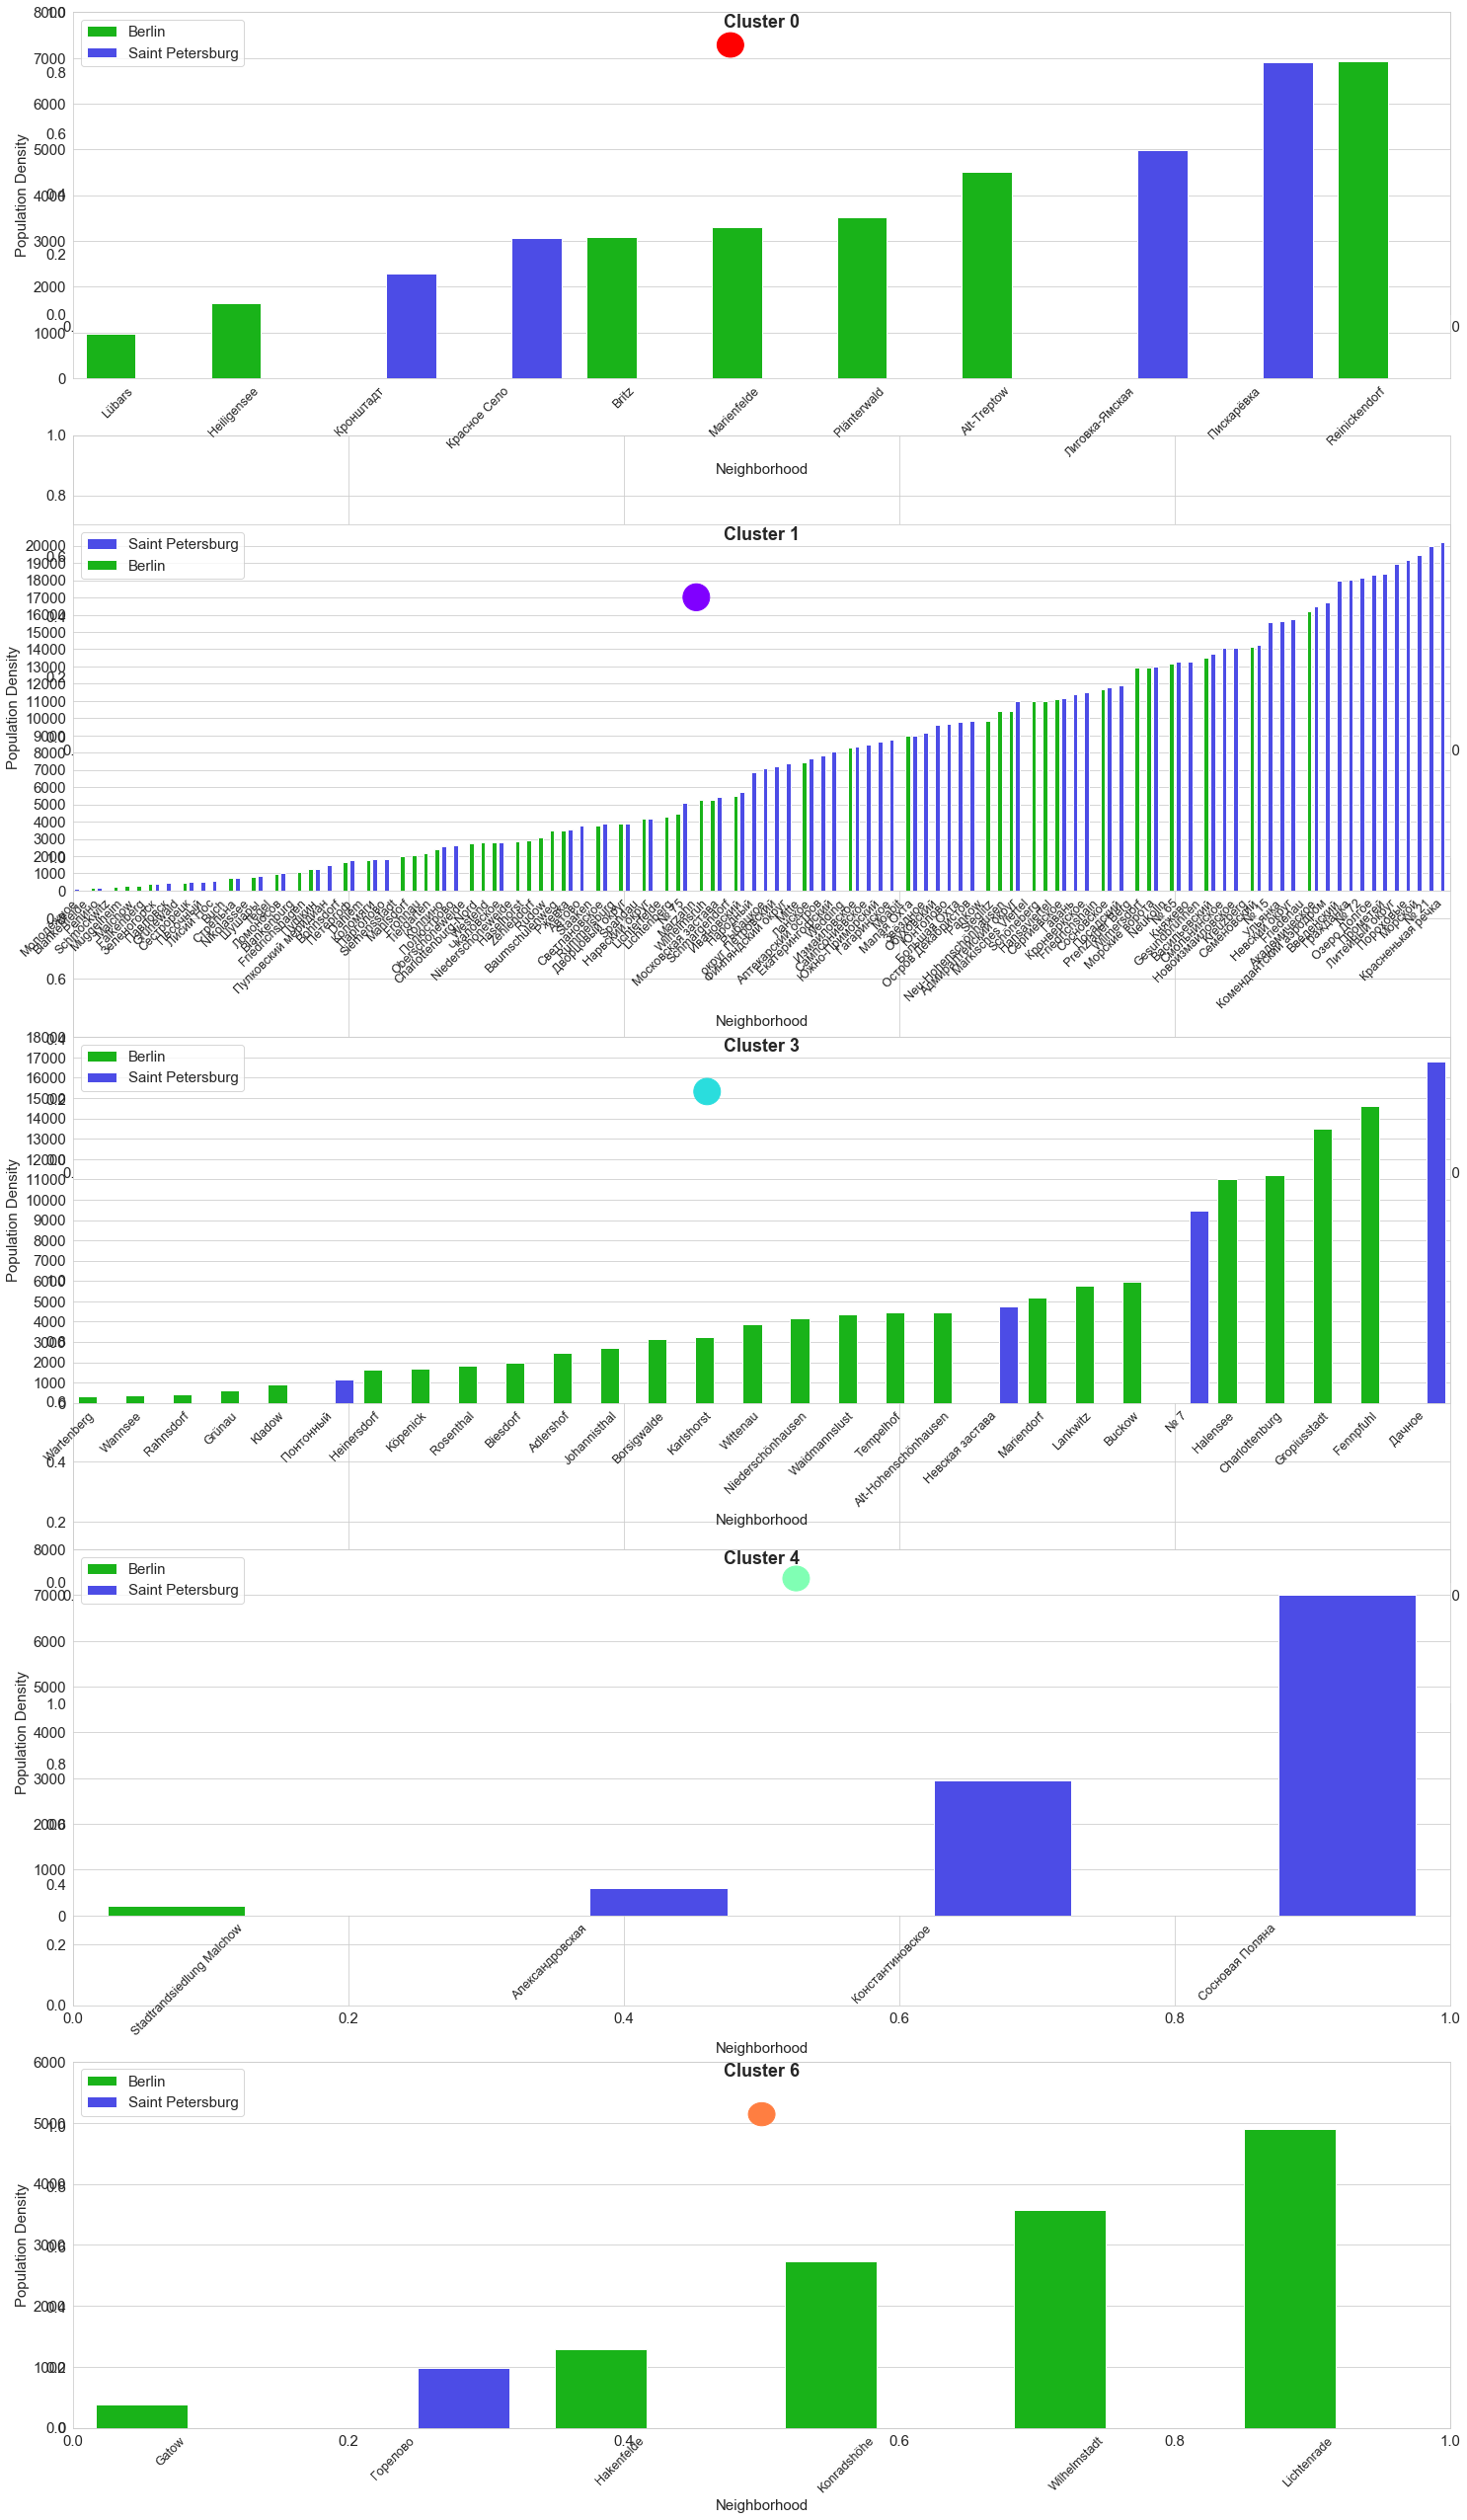

In [161]:
#initialising the figure
plt.rcParams["axes.grid"] = False
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=len(mergingclusters)+1,figsize=(25, 45))
ax = ax.flatten()
plt.subplots_adjust(hspace=0.4)


for i in range(1,len(mergingclusters)+1):
    #obtaining the dataframe whith neighborhoods from overlapping clusters only
    df_temp=df_final[df_final['Cluster Labels']==mergingclusters[i-1]].sort_values('Density')
    #adding the limits on neighborhoods to display
    if min(len(df_temp[df_temp['City']=='Berlin']['Density']),len(df_temp[df_temp['City']=='Saint Petersburg']['Density']))>1:
       upperbottom=min(max(df_temp[df_temp['City']=='Berlin']['Density']),max(df_temp[df_temp['City']=='Saint Petersburg']['Density']))
       lowerbottom=max(min(df_temp[df_temp['City']=='Berlin']['Density']),min(df_temp[df_temp['City']=='Saint Petersburg']['Density']))
    else: 
       upperbottom=max(df_temp['Density'])
       lowerbottom=min(df_temp['Density'])
       
    cond1=df_temp['Density']>0.75*lowerbottom
    cond2=df_temp['Density']<1.25*upperbottom
    df_temp2=df_temp[cond1&cond2]
    
    #plotting the barplots for each cluster  
    ax[i]=fig.add_subplot(len(mergingclusters),1,i)
    ax[i]=sns.barplot(x='Neighborhood', y='Density', hue='City', data=df_temp2,palette=colordict)

    #configuring the legend
    ax[i].legend(ncol=1, loc="upper left", frameon=True,fontsize='medium')
    
    #configuring the neighborhood axis 
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right',fontsize='small')
    
    #configuring the density axis
    ax[i].set_ylabel('Population Density')
    ax[i].set_yticks(np.arange(0, 1.25*upperbottom, 1000))
    
    
    
    #adding the cluster name and cluster marker on top of each plot
    ax[i].set_title ('Cluster '+str(mergingclusters[i-1]),fontdict={'fontsize':'large','fontweight':'bold'},pad=-15)
    
    horizontal=0.9*(len(df_temp2[df_temp2['Cluster Labels']==mergingclusters[i-1]]['Neighborhood'])/2)-0.2
    vertical=1.05*upperbottom
    width=4*(len(df_temp2[df_temp2['Cluster Labels']==mergingclusters[i-1]]['Neighborhood']))/len(df_final['Neighborhood'])
    height=4*width*max(df_temp2[df_temp2['Cluster Labels']==mergingclusters[i-1]]['Density'])/(len(df_temp2[df_temp2['Cluster Labels']==mergingclusters[i-1]]['Neighborhood']))
    clustermarker=Ellipse((horizontal,vertical),width,height,color=rainbow[mergingclusters[i-1]-1],fill=True,linewidth=1)
    ax[i].add_patch(clustermarker)
    
plt.show()

That's it! 

In [146]:
i=4
df_temp=df_final[df_final['Cluster Labels']==mergingclusters[i-1]].sort_values('Density')
    #adding the limits on neighborhoods to display
if min(len(df_temp[df_temp['City']=='Berlin']['Density']),len(df_temp[df_temp['City']=='Saint Petersburg']['Density']))>1:
       upperbottom=min(max(df_temp[df_temp['City']=='Berlin']['Density']),max(df_temp[df_temp['City']=='Saint Petersburg']['Density']))
       lowerbottom=max(min(df_temp[df_temp['City']=='Berlin']['Density']),min(df_temp[df_temp['City']=='Saint Petersburg']['Density']))
else: 
       upperbottom=max(df_temp['Density'])
       lowerbottom=min(df_temp['Density'])
       
cond1=df_temp['Density']>0.75*lowerbottom
cond2=df_temp['Density']<1.25*upperbottom
df_temp2=df_temp[cond1&cond2]

0.9*(len(df_temp2[df_temp2['Cluster Labels']==mergingclusters[i-1]]['Neighborhood']))/2

1.8

## Results and Discussion <a name="results"></a>

Analysis shows, that out of 207 neighborhoods (111 in Saint Petersburg and 96 in Berlin) there are total of 190 neighborhoods, inhabitans of which can find a neighborhood with similar vibe in a different city. In total:
 - 92.56% of Saint Petersburg inhabitans can find a neighborhood of same cluster in Berlin
 - 91.0% of Berlin inhabitans can find a neighborhood of same cluster in Saint Petersburg:
 
As there are different numbers of neighborhoods of each cluster in two cities, moving from one city to another can be easier or harder, depending on the cluster you currently reside:
 * It's easier to move from Saint Petersburg to Berlin, if you live in a neighborhood of cluster 3
 * It's easier to move from Berlin to Saint Petersburg, if you live in cluster 1
 
So, majority of people can find a place somewhat similar to one they currently live, but adding restrictions on density difference drops the number of similar neighborhoods - putting the +-25% limit on density difference on average drops the number of suitable neighborhoods to 1-10, depending on the city


## Conclusion <a name="conclusion"></a>

Project was designed to provide the calculated advice to a person, willing to relocate, keeping the same vibe and population density and we provided a plot of all suitable neighborhoods, where such relocation is possible

Final decision on most suitable neighborhood is up to the user and it can vary, depending of his geographical preferancies, such as proximity to city center, river, or other sites